In [455]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import log10, floor, ceil
import re

import warnings
warnings.filterwarnings("ignore")

In [540]:

def splitIsotope(isotope):
    parts = re.findall(r'(\d+|[a-zA-Z]+)', isotope)
    return parts

PATH_TO_HIVAPS = '/home/adam/skola/phd/hivap/HIVAP-CODE/Hivap/MyHivap/results'
colors = ['red', 'limegreen', 'blue', 'gold', 'black', 'olive', 'grey', 'turquoise', 'magenta', 'brown', 'teal', 'maroon']



In [638]:
class Reaction:
    def __init__(self, projectile, target, cn, barfac, unit='mb', evap_channel='xn', sigr=2.5, bf_diff=0.00, channels_to_show=[], lowYRange=0, highYRange=0, lowXRange=0, highXRange=0):
        self.projectile = projectile
        self.target = target
        self.cn = cn
        self.barfac = barfac
        self.unit = unit
        self.evap_channel = evap_channel
        self.sigr = sigr
        self.bf_diff = bf_diff
        self.data_ifus0, self.data_ifus10 = None, None
        self.data_ifus0_bf_low, self.data_ifus0_bf_high, self.data_ifus10_bf_low, self.data_ifus10_bf_high = None, None, None, None
        self.channels_to_show = channels_to_show
        self.lowYRange = lowYRange
        self.highYRange = highYRange
        self.lowXRange = lowXRange
        self.highXRange = highXRange
        self.__getData()
        
        if not channels_to_show: # and (self.data_ifus0['isotope'].unique() == self.data_ifus10['isotope'].unique()).all():
            self.channels_to_show = self.data_ifus0['isotope'].unique()
        else:
            #add to self.channels_to_show only those that are in the data
            self.channels_to_show = []
            for channel in channels_to_show:
                if np.any(self.data_ifus0['isotope'].unique() == channel):
                    self.channels_to_show.append(channel)
                    
        if lowYRange == 0:
            self.lowYRange = self.__lowYRange()
            
        if highYRange == 0:
            self.highYRange = self.__highYRange()
                    
        if lowXRange == 0:
            self.lowXRange = self.__lowXRange()
            
        if highXRange == 0:
            self.highXRange = self.__highXRange()
                
                
        if self.bf_diff > 0:
            self.__getBfDiffData()
            
    def isotopeA(self, isotope):
        return int(splitIsotope(isotope)[0])
    
    def isotopeElement(self, isotope):
        return splitIsotope(isotope)[1]
    
    def __getData(self):
        # get data into variable
        try:
            self.data_ifus0 = pd.read_csv(PATH_TO_HIVAPS + '/' + self.cn.lower() + '/data/' + self.projectile + '_' + self.target + '_' + self.cn + '_' + self.evap_channel + '_' + 'IFUS0' + '_barfac' + f'{self.barfac:.2f}' + '_sigr' + str(self.sigr) + '.dat', sep='\t')
            
            self.data_ifus10 = pd.read_csv(PATH_TO_HIVAPS + '/' + self.cn.lower() + '/data/' + self.projectile + '_' + self.target + '_' + self.cn + '_' + self.evap_channel + '_' + 'IFUS10' + '_barfac' + f'{self.barfac:.2f}' + '_sigr' + str(self.sigr) + '.dat', sep='\t')
            
            
            self.data_ifus0 = self.data_ifus0.melt(id_vars=['E_lab', 'E*/MeV'], var_name='isotope', value_name='CS')
            self.data_ifus10 = self.data_ifus10.melt(id_vars=['E_lab', 'E*/MeV'], var_name='isotope', value_name='CS')
            
            self.__scaleData(self.data_ifus0)
            self.__scaleData(self.data_ifus10)
            
        except:
            print('No data found')
            self.data_ifus0, self.data_ifus10 = None, None
            
    def __getBfDiffData(self):
        # get data into variable
        try:
            self.data_ifus0_bf_low = pd.read_csv(PATH_TO_HIVAPS + '/' + self.cn.lower() + '/data/' + self.projectile + '_' + self.target + '_' + self.cn + '_' + self.evap_channel + '_' + 'IFUS0' + '_barfac' + f'{self.barfac-self.bf_diff:.2f}' + '_sigr' + str(self.sigr) + '.dat', sep='\t')
            
            self.data_ifus0_bf_high = pd.read_csv(PATH_TO_HIVAPS + '/' + self.cn.lower() + '/data/' + self.projectile + '_' + self.target + '_' + self.cn + '_' + self.evap_channel + '_' + 'IFUS0' + '_barfac' + f'{self.barfac+self.bf_diff:.2f}' + '_sigr' + str(self.sigr) + '.dat', sep='\t')
            
            
            self.data_ifus10_bf_low = pd.read_csv(PATH_TO_HIVAPS + '/' + self.cn.lower() + '/data/' + self.projectile + '_' + self.target + '_' + self.cn + '_' + self.evap_channel + '_' + 'IFUS10' + '_barfac' + f'{self.barfac-self.bf_diff:.2f}' + '_sigr' + str(self.sigr) + '.dat', sep='\t')
            
            self.data_ifus10_bf_high = pd.read_csv(PATH_TO_HIVAPS + '/' + self.cn.lower() + '/data/' + self.projectile + '_' + self.target + '_' + self.cn + '_' + self.evap_channel + '_' + 'IFUS10' + '_barfac' + f'{self.barfac+self.bf_diff:.2f}' + '_sigr' + str(self.sigr) + '.dat', sep='\t')
            
            self.data_ifus0_bf_low = self.data_ifus0_bf_low.melt(id_vars=['E_lab', 'E*/MeV'], var_name='isotope', value_name='CS')
            self.data_ifus0_bf_high = self.data_ifus0_bf_high.melt(id_vars=['E_lab', 'E*/MeV'], var_name='isotope', value_name='CS')
            
            self.data_ifus10_bf_low = self.data_ifus10_bf_low.melt(id_vars=['E_lab', 'E*/MeV'], var_name='isotope', value_name='CS')
            self.data_ifus10_bf_high = self.data_ifus10_bf_high.melt(id_vars=['E_lab', 'E*/MeV'], var_name='isotope', value_name='CS')
            
            self.__scaleData(self.data_ifus0_bf_low)
            self.__scaleData(self.data_ifus0_bf_high)
            self.__scaleData(self.data_ifus10_bf_low)
            self.__scaleData(self.data_ifus10_bf_high)
            
        except:
            print('No data found')
            self.data_ifus0_bf_low, self.data_ifus0_bf_high, self.data_ifus10_bf_low, self.data_ifus10_bf_high = None, None, None, None
    
    def __scaleData(self, dataframe):
        scale = 1
        if self.unit == 'mb':
            scale = 1
        elif self.unit == 'ub':
            scale = 1e3
        elif self.unit == 'nb':
            scale = 1e6
            
        dataframe['CS'] = dataframe['CS'].multiply(scale)
        
    def __lowYRange(self):
        # find maximum of the 'smallest' excit. function (IFUS10) to be plotted and then set the minimum to 1 order lower
        lowest_max = float('inf')
        for channel in self.channels_to_show:
            if self.data_ifus10[self.data_ifus10['isotope'] == channel]['CS'].max() > 0 and self.data_ifus10[self.data_ifus10['isotope'] == channel]['CS'].max() < lowest_max:
                    lowest_max = self.data_ifus10[self.data_ifus10['isotope'] == channel]['CS'].max()
        return (10**round(log10(lowest_max))/10)

    def __highYRange(self):
        # find maximum of the 'largest' excit. function (IFUS10) to be plotted and set the maximum to 1 order higher
        highest_max = 0
        for channel in self.channels_to_show:
            if self.data_ifus10[self.data_ifus10['isotope'] == channel]['CS'].max() > 0 and self.data_ifus10[self.data_ifus10['isotope'] == channel]['CS'].max() > highest_max:
                highest_max = self.data_ifus10[self.data_ifus10['isotope'] == channel]['CS'].max()
        return (10**round(log10(highest_max))*10)
        
    def __lowXRange(self):
        # get minimum energy for which the CS value is larger than lowYRange
        return floor(self.data_ifus10[self.data_ifus10['isotope'].isin(self.channels_to_show)][self.data_ifus10['CS'] > self.lowYRange]['E_lab'].min()/10)*10
        
    def __highXRange(self):
        # get maximum energy for which the CS value is larger than lowYRange
        return ceil(self.data_ifus10[self.data_ifus10['isotope'].isin(self.channels_to_show)][self.data_ifus10['CS'] > self.lowYRange]['E_lab'].max()/10)*10
    
    
    def plot(self, plot_diff=True, alpha_value=0.1, show_title=False):
        fig, ax = plt.subplots(figsize=(12,6))
        
        sns.lineplot(x='E_lab', y='CS', hue='isotope', data=self.data_ifus10[self.data_ifus10['isotope'].isin(self.channels_to_show)], palette=colors)
        sns.lineplot(x='E_lab', y='CS', hue='isotope', data=self.data_ifus0[self.data_ifus0['isotope'].isin(self.channels_to_show)], legend=None, linestyle='--', palette=colors)
        for text in plt.legend(loc='upper right').get_texts():
            label = text.get_text()
            text.set_text('$^{' + str(self.isotopeA(label)) + '}$' + self.isotopeElement(label))
        
        plt.semilogy()
        plt.ylim(self.lowYRange, self.highYRange)
        plt.xlim(self.lowXRange, self.highXRange)
        if self.unit == 'ub':
            plt.ylabel('$\sigma$ [$\mu$b]', fontsize=20)
        else:
            plt.ylabel(f'$\sigma$ [{self.unit}]', fontsize=20)

        plt.xlabel('$E_{proj}$ [MeV]', fontsize=20)
        
        if show_title:
            plt.title(r'$^{' + str(self.isotopeA(self.projectile)) + '}$' + self.isotopeElement(self.projectile) + r' + $^{' + str(self.isotopeA(self.target)) + '}$' + self.isotopeElement(self.target) + r' $\rightarrow$ $^{' + str(self.isotopeA(self.cn)) + '}$' + self.isotopeElement(self.cn) + r'$^*$, BF = ' + str(self.barfac) + str('' if self.bf_diff == 0 else (r' $\pm$ ' + str(self.bf_diff))))
        
        if plot_diff and self.bf_diff > 0:
            self.__plotBfDiff(alpha_value)

    def __plotBfDiff(self, alpha_value):
        for index, channel in enumerate(self.channels_to_show):
            plt.fill_between(self.data_ifus0[self.data_ifus0['isotope'] == channel]['E_lab'],
                             self.data_ifus0[self.data_ifus0['isotope'] == channel]['CS'],
                             self.data_ifus0_bf_low[self.data_ifus0_bf_low['isotope'] == channel]['CS'],
                             color=colors[index], alpha=alpha_value)

            plt.fill_between(self.data_ifus0[self.data_ifus0['isotope'] == channel]['E_lab'], 
                             self.data_ifus0[self.data_ifus0['isotope'] == channel]['CS'], 
                             self.data_ifus0_bf_high[self.data_ifus0_bf_high['isotope'] == channel]['CS'], 
                             color=colors[index], alpha=alpha_value)

            plt.fill_between(self.data_ifus10[self.data_ifus10['isotope'] == channel]['E_lab'], 
                             self.data_ifus10[self.data_ifus10['isotope'] == channel]['CS'], 
                             self.data_ifus10_bf_low[self.data_ifus10_bf_low['isotope'] == channel]['CS'], 
                             color=colors[index], alpha=alpha_value)

            plt.fill_between(self.data_ifus10[self.data_ifus10['isotope'] == channel]['E_lab'], 
                             self.data_ifus10[self.data_ifus10['isotope'] == channel]['CS'], 
                             self.data_ifus10_bf_high[self.data_ifus10_bf_high['isotope'] == channel]['CS'], 
                             color=colors[index], alpha=alpha_value)
                
    def saveFig(self, note='', extension='pdf'):
        extension_types = ['pdf', 'svg', 'png']
        if extension not in extension_types:
            raise ValueError('Invalid extension type, please choose one from: %s' % extension_types)
            
        plt.savefig('figs/' + self.projectile + '_' + self.target + '_' + self.cn + '_' + self.evap_channel + '_barfac' + f'{self.barfac:.2f}' + '_sigr' + str(self.sigr) + str('' if len(note) == 0 else '_') + note + '.' + extension, bbox_inches='tight')
    

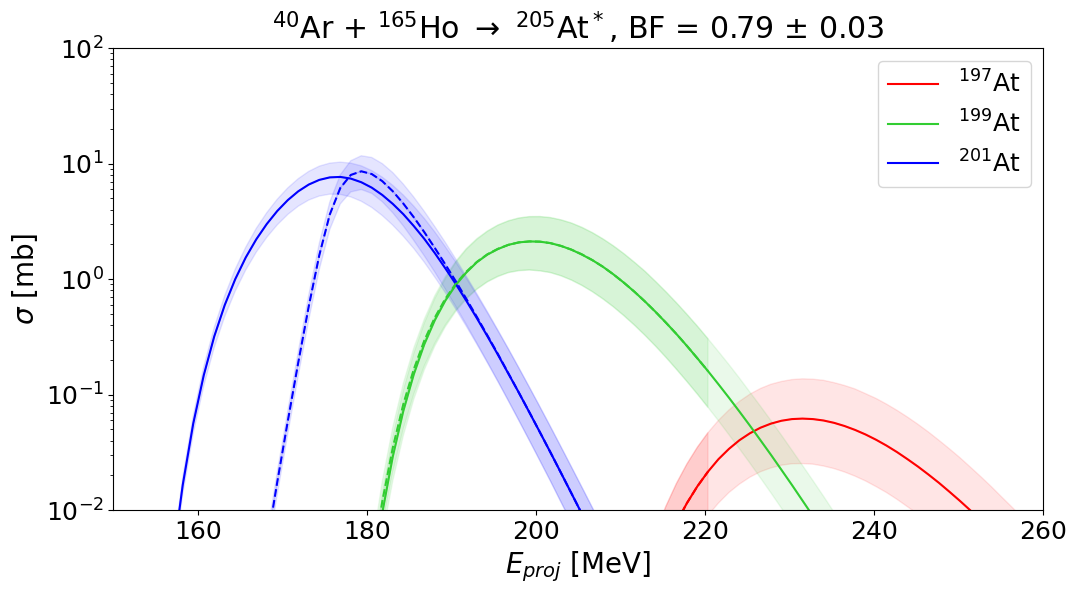

In [639]:
reaction1 = Reaction('40Ar', '165Ho', '205At', 0.79, evap_channel='xn', sigr=3.3, channels_to_show=['197At', '199At', '201At'], bf_diff=0.03)
reaction1.plot(show_title=True)
# reaction1.saveFig(note='')



In [543]:
reaction1.data_ifus10[reaction1.data_ifus10['isotope'] == '195At']['CS']
reaction1.data_ifus0[reaction1.data_ifus10['isotope'] == '195At']['E_lab']

0      164.401
1      165.643
2      166.886
3      168.128
4      169.371
        ...   
106    181.795
107    183.037
108    184.280
109    185.522
110    186.765
Name: E_lab, Length: 111, dtype: float64

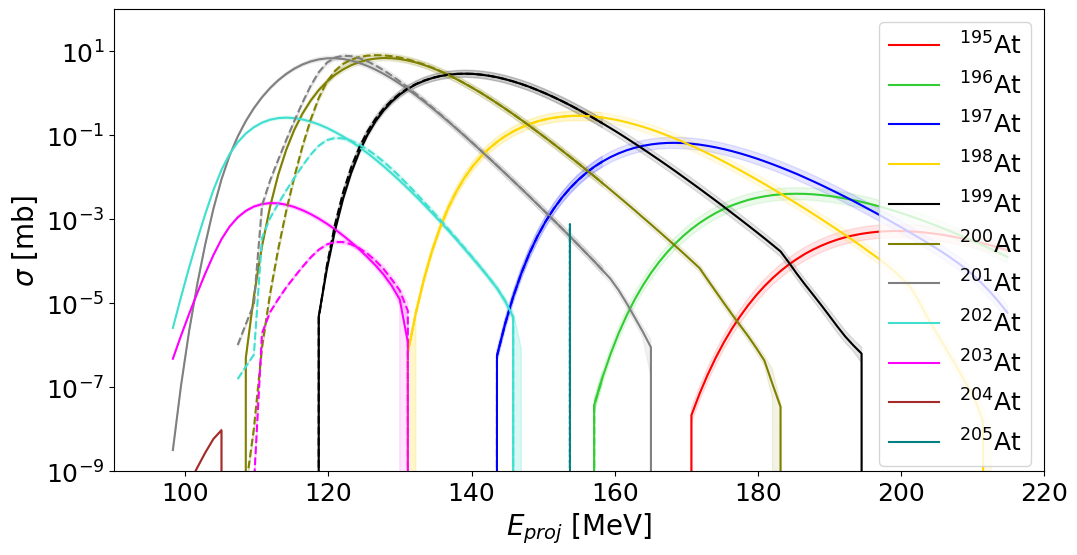

In [546]:
reaction2 = Reaction('24Mg', '181Ta', '205At', 0.77, unit='mb', evap_channel='xn', sigr=3.2, bf_diff=0.01)
reaction2.plot()


In [539]:
a= ['a', 'b', 'c']
for index, value in enumerate(a):
    print(index, value)

0 a
1 b
2 c
